In [7]:
import pandas as pd
import numpy as np
from sklearn import svm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.model_selection import train_test_split
from skimage import color
import tensorflow as tf
from skimage.feature import hog
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [8]:
# Check for GPU availability
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print('GPU is available')
else:
    print('No GPU detected')

num_gpus = len(physical_devices)

if num_gpus > 0:
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {tf.config.experimental.get_device_details(physical_devices[0])}")
else:
    print("No GPUs available")

device = tf.device('gpu:0' if len(physical_devices) > 0 else 'cpu:0')

GPU is available
Number of available GPUs: 1
GPU 0: {'device_name': 'NVIDIA GeForce RTX 3060 Ti', 'compute_capability': (8, 6)}


In [12]:
# Function to extract PCA features from an image
def extract_pca_features(image, n_components=50):
    # Assuming image is a 3D array representing the color image
    # Reshape to (num_pixels, num_channels)
    flat_image = image.reshape((-1, image.shape[-1]))
    
    # Apply PCA
    pca = PCA(n_components=min(n_components, flat_image.shape[0], flat_image.shape[1]))
    pca_features = pca.fit_transform(flat_image)
    return pca_features.flatten()

In [4]:
# Load the dataset using the provided code
data_dir = 'd:\\Rice_Image_Dataset\\Dataset\\Dataset'
train_data = image_dataset_from_directory(data_dir, shuffle=True, batch_size=64, image_size=(128, 128))

Found 500 files belonging to 5 classes.


In [10]:
# Extract PCA features from the training set
n_components = 50  # Adjust the number of components based on your requirements
train_features = []
train_labels = []

# Feature extraction using PCA

In [13]:
for images, labels in train_data:
    features = []
    for image in images.numpy():
        pca_features = extract_pca_features(image, n_components=n_components)
        features.append(pca_features)
    train_features.extend(features)
    train_labels.extend(labels.numpy())

In [14]:
# Convert to NumPy arrays
train_features = np.array(train_features)
train_labels = np.array(train_labels)

In [15]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)


# RandomForestClassifier

In [16]:
# Train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# Predict on the test set
y_pred = random_forest_classifier.predict(X_test)

In [18]:
# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.97
Precision: 0.9715384615384616
Recall: 0.97
F1 Score: 0.9701322057787175


In [19]:
# Binarize labels for multiclass ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

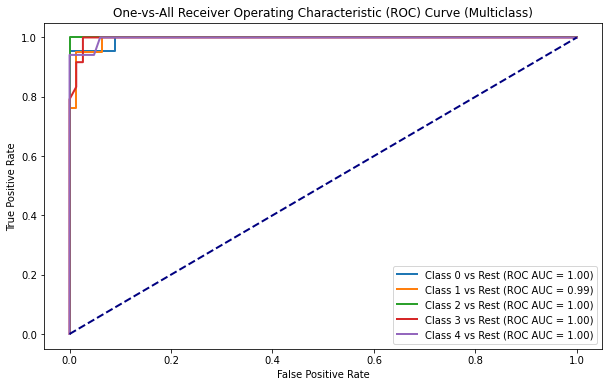

In [20]:
# Train a Random Forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_classifier.fit(X_train, y_train)

# Predict probabilities on the test set for ROC curve
y_probs = random_forest_classifier.predict_proba(X_test)

# Plot ROC curve for each class against the rest
plt.figure(figsize=(10, 6))
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} vs Rest (ROC AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One-vs-All Receiver Operating Characteristic (ROC) Curve (Multiclass)')
plt.legend(loc='lower right')
plt.show()

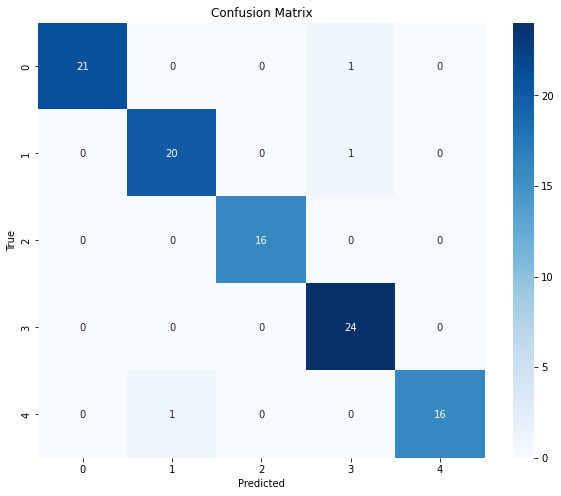

In [21]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()